Импорт билиотек

In [ ]:
import datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics  import roc_auc_score
from sklearn.model_selection import KFold, cross_val_score
%matplotlib inline

Импорт файлов

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving features.csv to features.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving features_test.csv to features_test.csv


In [ ]:
data = pd.read_csv('features.csv', index_col = 'match_id')
test = pd.read_csv('features_test.csv',index_col = 'match_id' )

In [ ]:
print(data.shape)
data.head()

(97230, 108)


,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,...,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,67,3,842,991,10,0,0,4,29,5,1909,1143,10,0,0,8,20,3,757,741,6,0,0,7,105,3,732,658,4,0,...,742,500,2,0,0,8,84,3,958,1003,3,1,0,9,7.0,1.0,9.0,NaN,134.0,-80.0,244.0,2,2,2,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,49,4,1596,993,10,0,1,7,67,4,1506,1502,18,1,0,7,37,3,669,631,7,0,0,7,26,2,415,539,1,0,...,440,583,0,0,0,7,12,4,1470,1622,24,0,0,9,54.0,1.0,7.0,NaN,173.0,-80.0,NaN,2,0,2,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,98,3,1314,775,6,0,0,6,20,3,1297,909,0,1,0,6,27,5,2360,2096,26,1,1,6,4,3,1395,1627,27,0,...,1319,667,4,0,0,7,80,3,1350,1512,25,0,0,7,224.0,0.0,3.0,NaN,63.0,-82.0,NaN,2,5,2,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,30,2,539,539,1,0,0,6,75,5,2037,1139,15,0,0,6,37,2,591,499,0,0,0,6,41,3,712,1075,12,0,...,674,537,1,0,0,7,20,2,510,499,0,0,0,7,NaN,NaN,NaN,NaN,208.0,-75.0,NaN,0,3,2,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,27,2,629,552,0,0,1,7,30,3,884,927,0,1,0,8,72,3,925,1439,16,1,0,11,93,4,1482,880,7,0,...,1815,1275,18,0,0,8,8,4,1119,904,6,0,1,7,-21.0,1.0,6.0,NaN,166.0,-81.0,181.0,1,4,2,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0,2449,0,4,1974,3,63


In [ ]:
y_train = data['radiant_win']
print(y_train.shape)
y_train.value_counts()

(97230,)


1    50414
0    46816
Name: radiant_win, dtype: int64

In [ ]:
x_train = data.drop(columns= ['duration', 'radiant_win', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire'])
print(x_train.shape)

(97230, 102)


In [ ]:
x_train.count()

start_time                  97230
lobby_type                  97230
r1_hero                     97230
r1_level                    97230
r1_xp                       97230
                            ...  
dire_tpscroll_count         97230
dire_boots_count            97230
dire_ward_observer_count    97230
dire_ward_sentry_count      97230
dire_first_ward_time        95404
Length: 102, dtype: int64

In [ ]:
columns_w_misses = []
for i in x_train.columns:
  if x_train[i].count() != 97230:
    a = 97230 - x_train[i].count() 
    dol = a / 97230
    columns_w_misses.append(i)
    print('Пропусков в ', i, ' : ', a , 'От общего кол-ва', ':', round(dol,2))

Пропусков в  first_blood_time  :  19553 От общего кол-ва : 0.2
Пропусков в  first_blood_team  :  19553 От общего кол-ва : 0.2
Пропусков в  first_blood_player1  :  19553 От общего кол-ва : 0.2
Пропусков в  first_blood_player2  :  43987 От общего кол-ва : 0.45
Пропусков в  radiant_bottle_time  :  15691 От общего кол-ва : 0.16
Пропусков в  radiant_courier_time  :  692 От общего кол-ва : 0.01
Пропусков в  radiant_flying_courier_time  :  27479 От общего кол-ва : 0.28
Пропусков в  radiant_first_ward_time  :  1836 От общего кол-ва : 0.02
Пропусков в  dire_bottle_time  :  16143 От общего кол-ва : 0.17
Пропусков в  dire_courier_time  :  676 От общего кол-ва : 0.01
Пропусков в  dire_flying_courier_time  :  26098 От общего кол-ва : 0.27
Пропусков в  dire_first_ward_time  :  1826 От общего кол-ва : 0.02


In [ ]:
columns_w_misses

['first_blood_time',
 'first_blood_team',
 'first_blood_player1',
 'first_blood_player2',
 'radiant_bottle_time',
 'radiant_courier_time',
 'radiant_flying_courier_time',
 'radiant_first_ward_time',
 'dire_bottle_time',
 'dire_courier_time',
 'dire_flying_courier_time',
 'dire_first_ward_time']

In [ ]:
#Заменим пропуски на нули с помощью функции fillna().
x_train = x_train.fillna(0)
y_train = y_train.fillna(0)


# **Подход 1: градиентный бустинг "в лоб"**

In [ ]:
kf = KFold(n_splits = 5, shuffle= True, random_state= 42) 

In [ ]:
def gb(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    scores = {}

    for n_estimators in [10, 20, 30, 50, 100, 250]:
        print(f"n_estimators={n_estimators}")
        model = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)

        start_time = datetime.datetime.now()
        score = cross_val_score(model, X, y, cv=kf, scoring="roc_auc", n_jobs=-1).mean()
        print(f"Score: {score:.3f}")
        print(f"Time elapsed: {datetime.datetime.now() - start_time}")

        scores[n_estimators] = score
        print()
        
    return pd.Series(scores)

n_estimators=10
Score: 0.665
Time elapsed: 0:00:43.578992

n_estimators=20
Score: 0.682
Time elapsed: 0:01:23.064391

n_estimators=30
Score: 0.690
Time elapsed: 0:02:04.612379

n_estimators=50
Score: 0.697
Time elapsed: 0:03:28.210979

n_estimators=100
Score: 0.706
Time elapsed: 0:06:44.453372

n_estimators=250
Score: 0.716
Time elapsed: 0:16:34.721908



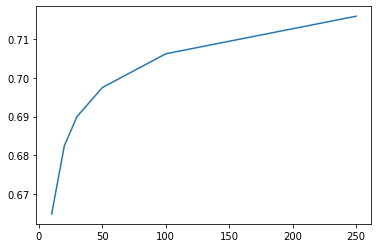

In [ ]:
scores = gb(x_train, y_train)
scores.plot()

**Отчет**


1.   Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?

`first_blood_player2` (второй игрок, причастный к событию) - первое убийство может быть совершено одним игроком, это достаточно частое явление и происходит в 45% случаев.

`first_blood_time` (игровое время первой крови) - в 20% случаев первой крови  нет в первые 5 минут игры.

2.   Как называется столбец, содержащий целевую переменную? 

 `radiant_win`



3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти ниже по тексту. Какое качество при этом получилось?

Время: `0:02:04`, Качество: `0.69`

4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

Да, имеет. Для ускорения обучения можно уменьшить количество деревьев и использовать лишь часть выборки для обучения.



# **Подход 2: логистическая регрессия**

In [ ]:
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), index=x_train.index, columns=x_train.columns)

In [ ]:

def lr(X: pd.DataFrame, y: pd.Series):
    scores = {}

    for i in range(-3, 3):
        C = 10.0 ** i

        print(f"C={C}")
        model = LogisticRegression(C=C, random_state=42)

        start_time = datetime.datetime.now()
        score = cross_val_score(model, X, y, cv=kf, scoring="roc_auc", n_jobs=-1).mean()
        print(f"Score: {score:.3f}")
        print(f"Time elapsed: {datetime.datetime.now() - start_time}")

        scores[i] = score
        print()

    return pd.Series(scores)

C=0.001
Score: 0.716
Time elapsed: 0:00:05.042364

C=0.01
Score: 0.717
Time elapsed: 0:00:05.201621

C=0.1
Score: 0.717
Time elapsed: 0:00:05.303114

C=1.0
Score: 0.717
Time elapsed: 0:00:05.360192

C=10.0
Score: 0.717
Time elapsed: 0:00:05.440761

C=100.0
Score: 0.717
Time elapsed: 0:00:05.418822



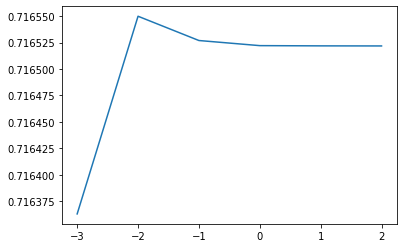

In [ ]:
scores = lr(x_train, y_train)
scores.plot()

In [ ]:
def print_best_lr_score(scores: pd.Series):
    best_iteration = scores.sort_values(ascending=False).head(1)
    best_C = 10.0 ** best_iteration.index[0]
    best_score = best_iteration.values[0]

    print(f"Наилучшее значение показателя AUC-ROC достигается при C = {best_C:.2f} и равно {best_score:.2f}.")

In [ ]:
print_best_lr_score(scores)

Наилучшее значение показателя AUC-ROC достигается при C = 0.01 и равно 0.72.


In [ ]:
hero_columns = [f"r{i}_hero" for i in range (1, 6)] + [f"d{i}_hero" for i in range (1, 6)]
ct_columns = ["lobby_type"] + hero_columns
x_train.drop(ct_columns, axis=1, inplace=True)

C=0.001
Score: 0.716
Time elapsed: 0:00:03.539686

C=0.01
Score: 0.717
Time elapsed: 0:00:04.882186

C=0.1
Score: 0.717
Time elapsed: 0:00:05.013004

C=1.0
Score: 0.717
Time elapsed: 0:00:04.936729

C=10.0
Score: 0.717
Time elapsed: 0:00:04.948335

C=100.0
Score: 0.717
Time elapsed: 0:00:05.088595



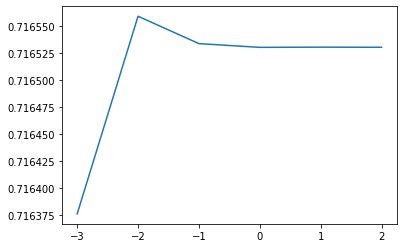

In [ ]:
scores = lr(x_train, y_train)
scores.plot()

In [ ]:
print_best_lr_score(scores)

Наилучшее значение показателя AUC-ROC достигается при C = 0.01 и равно 0.72.


In [ ]:
unique_heroes = np.unique(data[hero_columns].values.ravel())
N = max(unique_heroes)
print(f"Число уникальных героев в data: {len(unique_heroes)}. Максимальный ID героя: {N}.")

Число уникальных героев в data: 108. Максимальный ID героя: 112.


In [ ]:
def get_pick(data: pd.DataFrame):
    x_pick = np.zeros((data.shape[0], N))

    for i, match_id in enumerate(data.index):
        for p in range(1, 6):
            x_pick[i, data.loc[match_id, f"r{p}_hero"] - 1] = 1
            x_pick[i, data.loc[match_id, f"d{p}_hero"] - 1] = -1

    return pd.DataFrame(x_pick, index=data.index, columns=[f"hero_{i}" for i in range(N)])

x_pick = get_pick(data)
x_pick.head()

,hero_0,hero_1,hero_2,hero_3,hero_4,hero_5,hero_6,hero_7,hero_8,hero_9,hero_10,hero_11,hero_12,hero_13,hero_14,hero_15,hero_16,hero_17,hero_18,hero_19,hero_20,hero_21,hero_22,hero_23,hero_24,hero_25,hero_26,hero_27,hero_28,hero_29,hero_30,hero_31,hero_32,hero_33,hero_34,hero_35,hero_36,hero_37,hero_38,hero_39,...,hero_72,hero_73,hero_74,hero_75,hero_76,hero_77,hero_78,hero_79,hero_80,hero_81,hero_82,hero_83,hero_84,hero_85,hero_86,hero_87,hero_88,hero_89,hero_90,hero_91,hero_92,hero_93,hero_94,hero_95,hero_96,hero_97,hero_98,hero_99,hero_100,hero_101,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
x_train = pd.concat([x_train, x_pick], axis=1)

C=0.001


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Score: 0.746
Time elapsed: 0:00:08.526389

C=0.01
Score: 0.752
Time elapsed: 0:00:12.821616

C=0.1
Score: 0.752
Time elapsed: 0:00:16.725194

C=1.0
Score: 0.752
Time elapsed: 0:00:16.911217

C=10.0
Score: 0.752
Time elapsed: 0:00:16.916313

C=100.0
Score: 0.752
Time elapsed: 0:00:16.944013



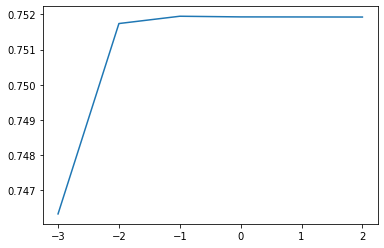

In [ ]:
scores = lr(x_train, y_train)
scores.plot()

In [ ]:
print_best_lr_score(scores)

Наилучшее значение показателя AUC-ROC достигается при C = 0.10 и равно 0.75.


In [ ]:
logreg = LogisticRegression(C=0.1, random_state=42)
logreg.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
test.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,...,d3_lh,d3_kills,d3_deaths,d3_items,d4_hero,d4_level,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,1430287923,0,93,4,1103,1089,8,0,1,9,102,3,1183,963,9,0,2,9,52,5,2289,2043,20,2,0,6,53,3,917,1006,14,0,0,6,57,3,1344,933,3,0,...,2,1,0,9,29,3,1091,918,6,0,1,8,39,5,1674,1048,12,0,1,7,1.0,0.0,2.0,NaN,72.0,-82.0,NaN,2,2,3,0,12.0,247.0,-86.0,272.0,3,4,2,0,118.0
7,1430293357,1,20,2,556,570,1,0,0,9,6,4,1194,1386,21,0,0,7,65,4,1374,1064,13,0,1,8,92,2,774,737,0,1,0,8,43,5,2254,1787,24,0,...,19,0,0,14,99,3,1075,718,3,0,1,7,5,4,1130,994,1,1,0,10,84.0,1.0,9.0,NaN,138.0,-82.0,233.0,2,6,2,2,-29.0,168.0,-54.0,NaN,3,2,2,1,16.0
10,1430301774,1,112,2,751,808,1,0,0,13,26,2,421,569,3,0,0,6,29,3,960,896,3,1,2,6,11,5,1877,1511,23,0,0,8,41,4,1581,1593,26,0,...,12,0,0,8,49,5,2434,1917,22,0,0,9,54,4,1372,2005,24,2,1,11,168.0,1.0,9.0,NaN,33.0,-88.0,NaN,5,4,3,1,-22.0,46.0,-87.0,186.0,1,3,3,0,-34.0
13,1430323933,1,27,3,708,903,1,1,1,11,91,2,672,901,6,0,0,8,74,5,2141,1626,28,0,0,7,52,4,1579,2169,28,2,0,7,2,5,1960,1668,27,0,...,22,0,0,7,62,2,536,692,0,1,1,6,49,4,1815,1424,18,0,0,5,55.0,0.0,3.0,NaN,208.0,-78.0,180.0,4,2,2,2,-49.0,30.0,-89.0,210.0,3,4,2,1,-26.0
16,1430331112,1,39,4,1259,661,4,0,0,9,93,5,1703,964,10,0,1,6,30,3,1099,942,2,1,0,6,85,3,1285,1013,10,0,0,8,102,2,484,609,4,0,...,19,0,0,10,3,3,623,520,1,0,0,10,96,5,1884,1409,15,0,1,11,285.0,1.0,5.0,NaN,225.0,-76.0,NaN,1,3,2,0,36.0,180.0,-86.0,180.0,1,3,2,1,-33.0


In [ ]:
test.fillna(0, inplace=True)

In [ ]:
x_test = pd.DataFrame(scaler.transform(test), index=test.index, columns=test.columns)
x_test.drop(cat_columns, axis=1, inplace=True)
x_test = pd.concat([x_test, get_pick(test)], axis=1)
x_test.head()

,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,r5_items,d1_level,d1_xp,d1_gold,d1_lh,...,hero_72,hero_73,hero_74,hero_75,hero_76,hero_77,hero_78,hero_79,hero_80,hero_81,hero_82,hero_83,hero_84,hero_85,hero_86,hero_87,hero_88,hero_89,hero_90,hero_91,hero_92,hero_93,hero_94,hero_95,hero_96,hero_97,hero_98,hero_99,hero_100,hero_101,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,-2.528200,0.501314,-0.230161,-0.126909,-0.357459,-0.537757,1.017574,0.291758,-0.332256,-0.011207,-0.316298,-0.164037,-0.533149,2.621540,0.297642,1.50723,1.993380,2.074565,1.080012,2.558429,-0.578154,-0.931725,-0.282744,-0.439414,-0.168958,0.450562,-0.525343,-0.579877,-0.937075,-0.277630,0.335277,-0.328926,-0.781746,-0.524078,-0.573665,0.292704,-0.417344,-0.208467,-0.440022,-0.694327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-2.527214,-1.297676,-1.195592,-1.245180,-1.131661,-0.537757,-0.578083,0.291758,0.578881,0.008600,0.607286,1.173453,-0.533149,-0.582396,-0.524101,0.59158,0.344425,-0.078385,0.297961,-0.529081,1.039791,-0.112095,-1.198079,-0.698973,-0.766270,-1.119305,1.030097,-0.579877,-0.113291,1.547460,1.980794,1.555606,1.565051,-0.524078,-0.573665,-0.941451,-0.417344,-0.588452,-0.394282,0.526938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,-2.525688,-1.297676,-0.851426,-0.732370,-1.131661,-0.537757,-0.578083,1.893320,-1.243393,-1.383288,-1.176562,-0.832783,-0.533149,-0.582396,-0.934972,-0.32407,-0.401660,-0.447840,-0.819255,1.014674,2.657736,-0.931725,1.547927,1.303079,0.952390,1.459763,-0.525343,-0.579877,-0.113291,0.634915,0.763834,1.127504,1.788555,-0.524078,-0.573665,-1.764221,-0.417344,-0.984493,-1.036831,-1.138424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13,-2.521671,-0.398181,-0.927319,-0.527677,-1.131661,0.968527,1.017574,1.092539,-1.243393,-0.931329,-0.451669,-0.498410,-0.533149,-0.582396,-0.113229,1.50723,1.726664,1.157527,1.973784,-0.529081,-0.578154,-0.521910,0.632591,0.762180,2.413473,2.020430,2.585536,-0.579877,-0.525183,1.547460,1.449165,1.293007,1.900308,-0.524078,-0.573665,-0.118681,0.487716,0.028801,-0.973665,-0.694327,...,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
16,-2.520369,0.501314,0.045173,-1.049106,-0.799860,-0.537757,-0.578083,0.291758,1.490017,0.925122,-0.314114,-0.052580,-0.533149,1.019572,-0.934972,-0.32407,-0.151163,-0.346679,-0.930976,1.014674,-0.578154,-0.931725,-0.282744,0.228542,-0.153414,0.002029,-0.525343,-0.579877,-0.113291,-1.190175,-1.219828,-1.043901,-0.669994,-0.524078,-0.573665,-0.118681,0.487716,1.844881,1.152193,0.526938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
preds = logreg.predict_proba(x_test)
preds

array([[0.17612391, 0.82387609],
       [0.24693178, 0.75306822],
       [0.81221065, 0.18778935],
       ...,
       [0.76539734, 0.23460266],
       [0.3749618 , 0.6250382 ],
       [0.57385916, 0.42614084]])

In [ ]:
ppreds = pd.Series(preds[:,1])
ppreds.describe()

count    17177.000000
mean         0.517031
std          0.220963
min          0.008432
25%          0.346091
50%          0.522135
75%          0.691758
max          0.996372
dtype: float64

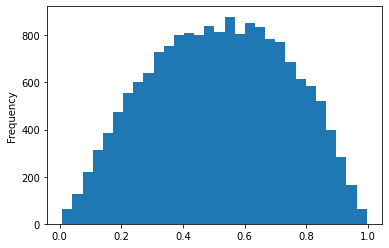

In [ ]:
ppreds.plot.hist(bins=30)

**Отчет**


1.   Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом? 

Качество: `0.717`

Полученное качество сопоставимо с градиентным бустингом с большим колличеством деревьев, при этом логистическая регрессия работает гораздо быстрее.



2.   Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение? 


Качество: `0.717`

Удаление категориальных признаков не повлияло на качество предсказания. Это значит, что модель не учла эти признаки.


3. Сколько различных идентификаторов героев существует в данной игре? 

`108`


4. Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?

Качество: `0.752` 

Качество улучшилось в связи с тем, что данные из id получили значение для модели


5. Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?  


min          `0.008429`

max          `0.996371`
